In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
df = pd.read_csv('news_uk_dataset.csv')


In [5]:
df.head(10)

,title,published,source,category
0,"The gift of Gabby: Gabby Logan on politics, mo...","Mon, 11 Jan 2010 08:00:00 GMT",www.independent.co.uk,Politics
1,Politics is full of slippery evasive liars: Af...,"Tue, 26 Jan 2010 08:00:00 GMT",www.dailymail.co.uk,Politics
2,BBC Comedy Blog: Mark Watson responds to Polit...,"Fri, 15 Jan 2010 08:00:00 GMT",www.bbc.co.uk,Politics
3,German politics set for shake-up as cancer for...,"Tue, 26 Jan 2010 08:00:00 GMT",www.independent.co.uk,Politics
4,The Big Question: What is the Tea Party moveme...,"Fri, 22 Jan 2010 08:00:00 GMT",www.independent.co.uk,Politics
5,"Here's to you, Mrs Robinson and putting politi...","Sun, 10 Jan 2010 08:00:00 GMT",www.thetimes.co.uk,Politics
6,Labour's computer blunders cost £26bn | The In...,"Tue, 19 Jan 2010 08:00:00 GMT",www.independent.co.uk,Politics
7,"BBC News - UK more liberal on homosexuality, s...","Tue, 26 Jan 2010 08:00:00 GMT",news.bbc.co.uk,Politics
8,Jyoti Basu: Marxist politician who combined re...,"Mon, 25 Jan 2010 08:00:00 GMT",www.independent.co.uk,Politics
9,Political sex scandals: The latest in a long t...,"Thu, 07 Jan 2010 08:00:00 GMT",www.independent.co.uk,Politics


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69588 entries, 0 to 69587
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      69588 non-null  object
 1   published  69588 non-null  object
 2   source     69588 non-null  object
 3   category   69588 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


In [7]:
df.describe().T

,count,unique,top,freq
title,69588,65443,BBC Blogs - Technology + Creativity at the BBC...,20
published,69588,7410,"Wed, 01 Mar 2017 08:00:00 GMT",89
source,69588,1502,www.bbc.co.uk,12615
category,69588,14,Police,8917


In [8]:
print(df.isnull().sum())


title        0
published    0
source       0
category     0
dtype: int64


In [9]:
df = df.drop_duplicates()


In [10]:
df['published'] = pd.to_datetime(df['published'])


In [11]:
# Feature engineering: Added new features - title length, & day of week.
df['title_length'] = df['title'].apply(len)
df['day_of_week'] = df['published'].dt.dayofweek

# Descriptive Statistics
print(df[['title_length', 'day_of_week']].describe())

       title_length   day_of_week
count  67635.000000  67635.000000
mean      80.540933      2.422000
std       24.484760      1.681808
min       11.000000      0.000000
25%       63.000000      1.000000
50%       77.000000      2.000000
75%       95.000000      4.000000
max      215.000000      6.000000


In [12]:
# Descriptive Statistics
print(df.describe())
print(df['category'].value_counts())
print(df['source'].value_counts())

                           published  title_length   day_of_week
count                          67635  67635.000000  67635.000000
mean   2017-12-20 12:55:05.328410112     80.540933      2.422000
min              2010-01-01 08:00:00     11.000000      0.000000
25%              2014-07-05 07:00:00     63.000000      1.000000
50%              2018-04-13 07:00:00     77.000000      2.000000
75%              2021-08-24 07:00:00     95.000000      4.000000
max              2024-05-05 01:32:46    215.000000      6.000000
std                              NaN     24.484760      1.681808
category
Police           8721
Crime            6563
Health           6240
Travel           6131
Education        5044
Entertainment    4889
Sports           4884
Politics         4358
International    4292
Science          4209
Culture          3198
Environment      3114
Economy          3110
Technology       2882
Name: count, dtype: int64
source
www.bbc.co.uk                        12330
www.independent.co.uk 

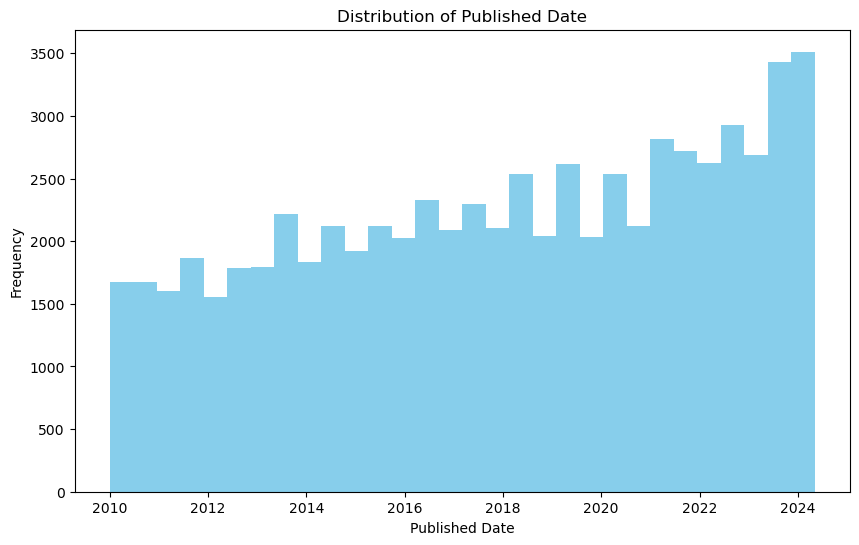

In [13]:
# Histogram for published date
plt.figure(figsize=(10, 6))
plt.hist(df['published'], bins=30, color='skyblue')
plt.title('Distribution of Published Date')
plt.xlabel('Published Date')
plt.ylabel('Frequency')
plt.show()

C:\Users\tomar\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\tomar\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\tomar\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


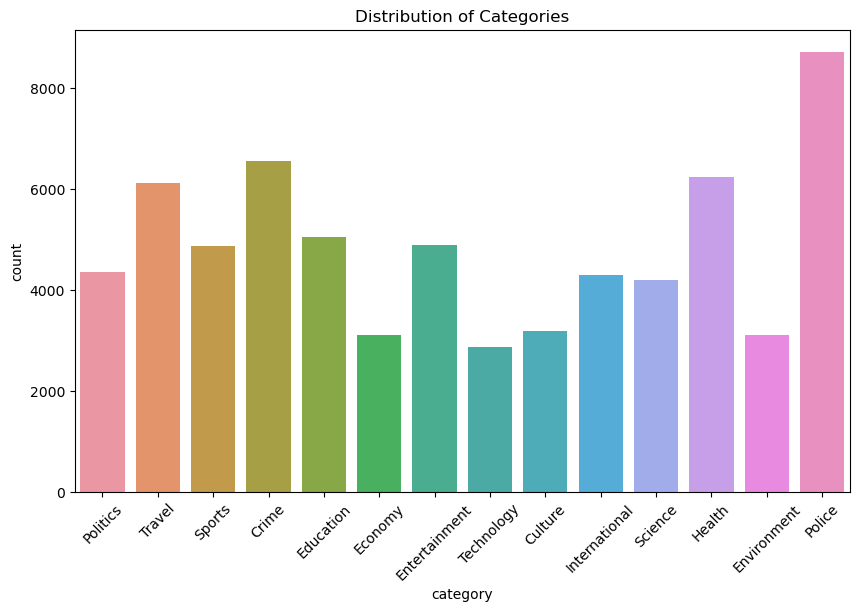

In [14]:
# Bar plot for category
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=df)
plt.title('Distribution of Categories')
plt.xticks(rotation=45)
plt.show()

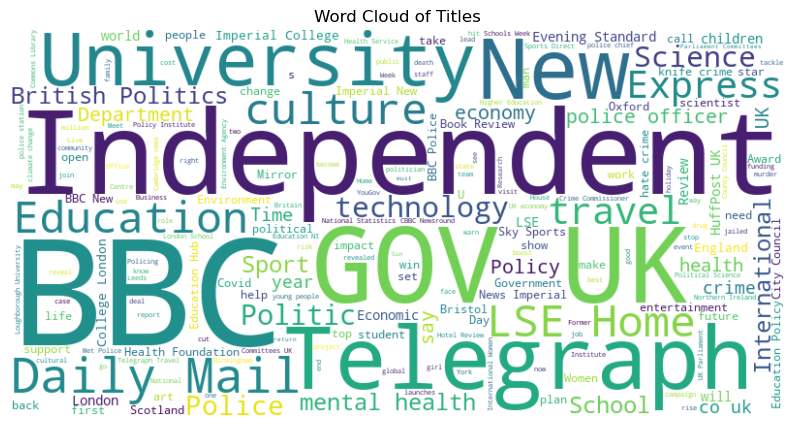

In [15]:

# Word cloud for titles
title_text = ' '.join(df['title'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Titles')
plt.axis('off')
plt.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tomar\AppData\Roaming\nltk_data...
C:\Users\tomar\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\tomar\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


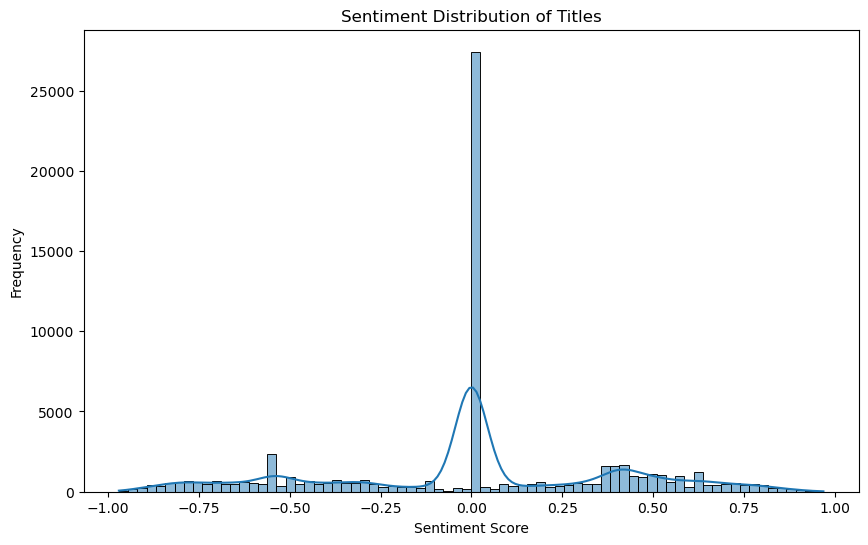

In [17]:
import nltk
nltk.download('vader_lexicon')
# Text Analysis (Sentiment Analysis)
sid = SentimentIntensityAnalyzer()
df['title_sentiment'] = df['title'].apply(lambda x: sid.polarity_scores(x)['compound'])
plt.figure(figsize=(10, 6))
sns.histplot(df['title_sentiment'], kde=True)
plt.title('Sentiment Distribution of Titles')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

C:\Users\tomar\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\tomar\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


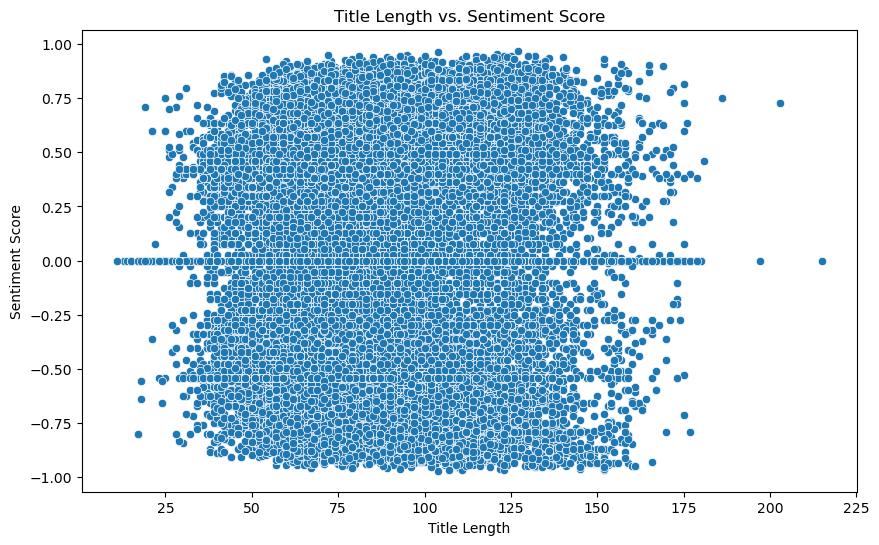

In [18]:
# Scatter plot of title length vs. sentiment score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='title_length', y='title_sentiment', data=df)
plt.title('Title Length vs. Sentiment Score')
plt.xlabel('Title Length')
plt.ylabel('Sentiment Score')
plt.show()

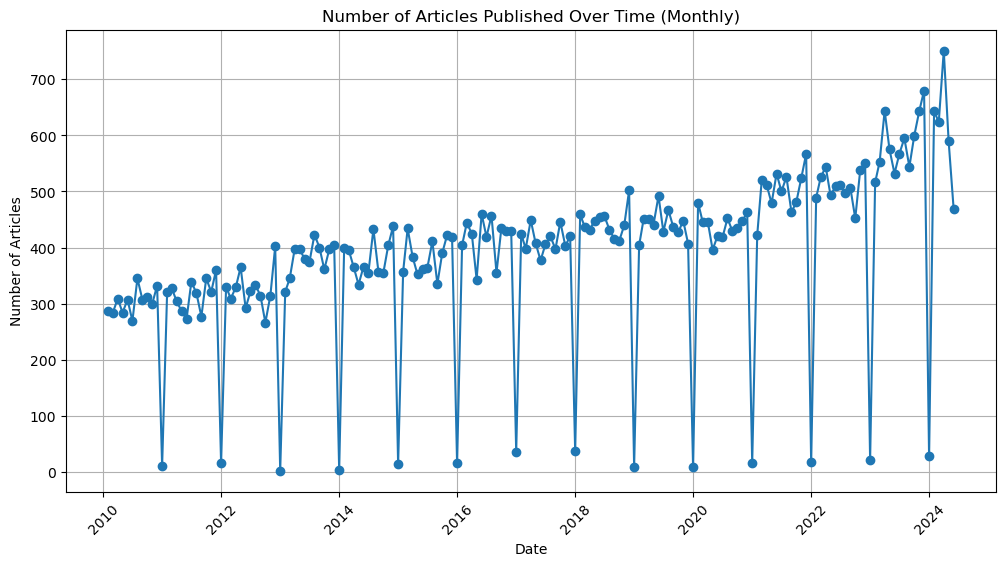

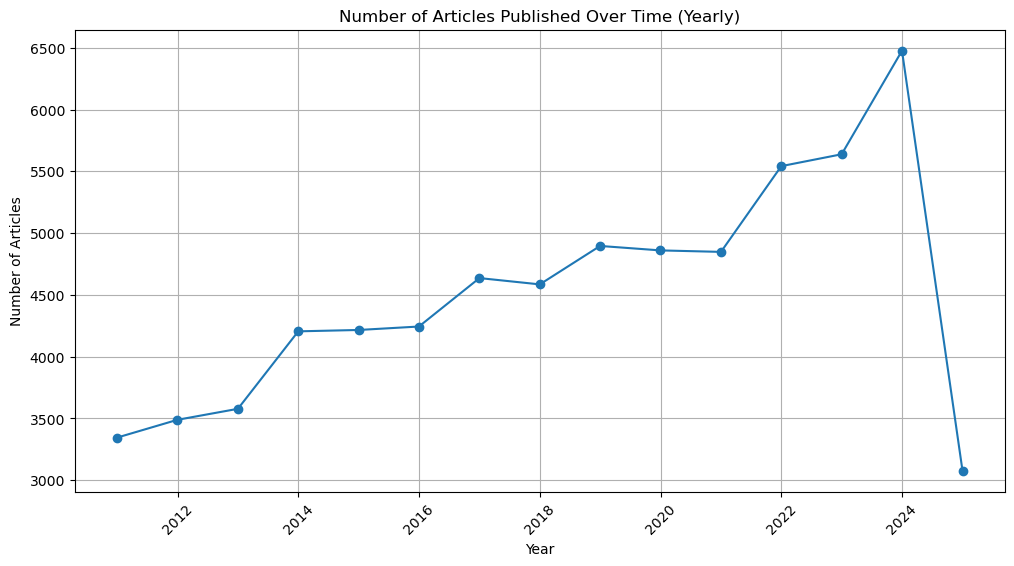

In [19]:
# Time Series Analysis
plt.figure(figsize=(12, 6))

# Resample data by month
df_monthly = df.resample('M', on='published').size()
plt.plot(df_monthly.index, df_monthly.values, marker='o', linestyle='-')
plt.title('Number of Articles Published Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Resample data by year
df_yearly = df.resample('Y', on='published').size()
plt.figure(figsize=(12, 6))
plt.plot(df_yearly.index, df_yearly.values, marker='o', linestyle='-')
plt.title('Number of Articles Published Over Time (Yearly)')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [20]:
# Association Rule Mining
# Convert categorical variables to binary form for association rule mining
df_binary = pd.get_dummies(df[['category', 'source']])

# Perform association rule mining using Apriori algorithm
frequent_itemsets = apriori(df_binary, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display the discovered association rules
print(rules)

              antecedents             consequents  antecedent support  \
0  (source_www.bbc.co.uk)       (category_Police)            0.182302   
1       (category_Police)  (source_www.bbc.co.uk)            0.128942   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.128942  0.050492    0.276967  2.147993  0.026985    1.204727   
1            0.182302  0.050492    0.391584  2.147993  0.026985    1.343977   

   zhangs_metric  
0       0.653602  
1       0.613563  


In [21]:
# Train a simple Random Forest classifier for text classification
X = df['title']
y = df['category']

# Feature extraction (e.g., TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Evaluate performance
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

C:\Users\tomar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\tomar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Accuracy: 0.8672285059510608


C:\Users\tomar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\tomar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\tomar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\tomar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Classification Report:


C:\Users\tomar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\tomar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\tomar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\tomar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

               precision    recall  f1-score   support

        Crime       0.87      0.88      0.87      1279
      Culture       0.93      0.89      0.91       668
      Economy       0.89      0.81      0.85       599
    Education       0.88      0.88      0.88       981
Entertainment       0.92      0.93      0.92      1002
  Environment       0.70      0.71      0.71       629
       Health       0.81      0.86      0.84      1244
International       0.92      0.87      0.90       893
       Police       0.93      0.91      0.92      1763
     Politics       0.82      0.84      0.83       881
      Science       0.74      0.77      0.76       873
       Sports       0.95      0.92      0.93       986
   Technology       0.83      0.74      0.78       562
       Travel       0.87      0.94      0.90      1167

     accuracy                           0.87     13527
    macro avg       0.86      0.85      0.86     13527
 weighted avg       0.87      0.87      0.87     13527



C:\Users\tomar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\tomar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\tomar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\tomar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

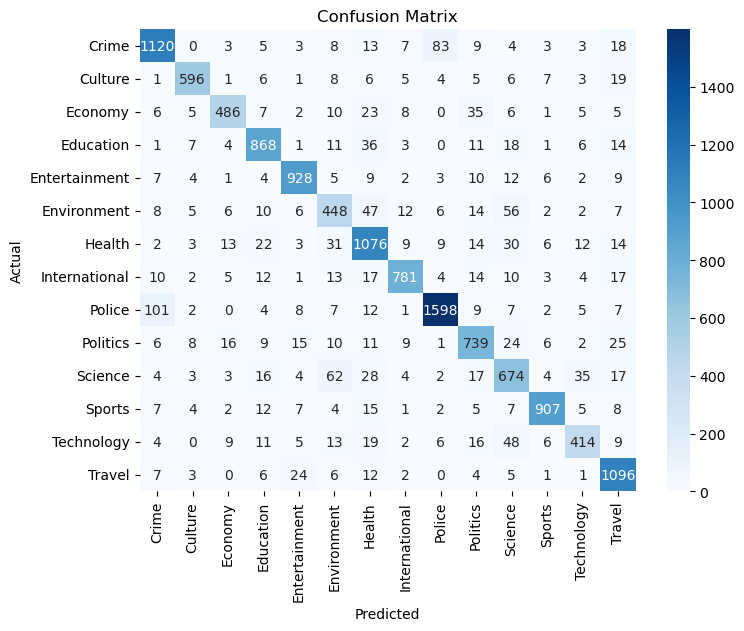

In [23]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Get class labels
class_labels = sorted(df['category'].unique())

# Plot confusion matrix with labels and colors
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

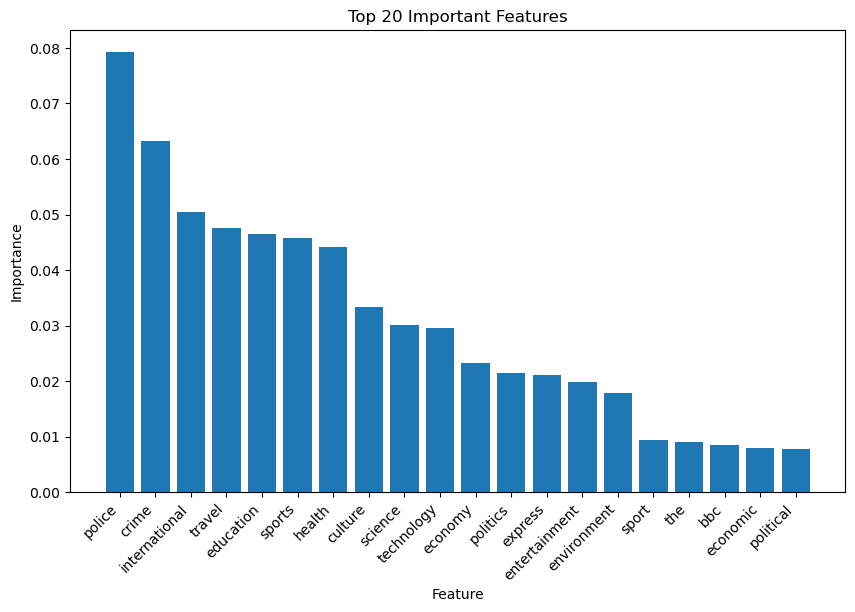

In [24]:
# Visualize feature importances
feature_names = tfidf_vectorizer.get_feature_names_out()
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = importances.argsort()[::-1]
top_n = 20
top_feature_names = [feature_names[i] for i in indices[:top_n]]
top_importances = importances[indices][:top_n]

# Plot top 20 important features
plt.figure(figsize=(10, 6))
plt.bar(top_feature_names, top_importances)
plt.title('Top 20 Important Features')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.show()